In [2]:
import cobra
import pandas as pd
import json
from copy import deepcopy
from custom_functions_scRBA import *

In [3]:
model = cobra.io.load_json_model('./models/cobraModel_constantStoichOnly.json')

with open('./models/symbolicStoich_lower_0_211.json') as f:
    coeffs_low = json.load(f)
with open('./models/symbolicStoich_higher_0_211.json') as f:
    coeffs_high = json.load(f)
    
coeffs_low = {tuple(k.split(' | ')):v for k,v in coeffs_low.items()}
coeffs_high = {tuple(k.split(' | ')):v for k,v in coeffs_high.items()}

Using license file /home/hvdinh16/Workspace/Softwares/gurobi910/linux64/gurobi.lic
Academic license - for non-commercial use only - expires 2021-07-26


In [4]:
model.solver = 'cplex'
model.solver.configuration.tolerances.feasibility = 1e-9
model.solver.configuration.tolerances.optimality = 1e-7

In [5]:
mu = 0.1

if mu < 0.211:
    coeffs = deepcopy(coeffs_low)
else:
    coeffs = deepcopy(coeffs_high)
coeffs = {k:eval(str(v)) for k,v in coeffs.items()}

for k,v in coeffs.items():
    r,m = k
    rxn = model.reactions.get_by_id(r)
    met = model.metabolites.get_by_id(m)
    rxn.add_metabolites({met:v})

In [6]:
model.reactions.get_by_id('DMRXNS-BIO-modeledProtBiom_m').bounds = (0,0)
model.reactions.get_by_id('DMRXNS-BIO-modeledProtBiom_c').bounds = (0,0)
model.reactions.get_by_id('DMRXNS-BIO-unmodeledProtBiom').bounds = (0,0)

model.reactions.get_by_id('BIODIL-BIODILRESPIRATION').bounds = (mu,mu)
model.reactions.get_by_id('BIODIL-BIODILFERMENTATION').bounds = (0,0)

#model.objective = dict()
#model.reactions.get_by_id('RXN-EX_glc__D_e_REV-SPONT').objective_coefficient = -1
#model.reactions.get_by_id('RXN-EX_glc__D_e_FWD-SPONT').objective_coefficient = 1

fba = model.optimize()
fba

,fluxes,reduced_costs
RXN-BTDDH_c_FWD-YAL060W,0.000000,-6.696900e-15
RXN-BTDDH_c_REV-YAL060W,0.000000,-3.979008e+00
RXN-13GS_c_FWD-GSC2RHO1,0.000000,-4.190353e-04
RXN-13GS_c_FWD-GSC1RHO1,0.098991,-1.708789e-14
RXN-16GS_c_FWD-YPR159W,0.026050,-1.730257e-14
...,...,...
BIODIL-BIODILRESPIRATION,0.100000,-2.174486e+03
DMRXNS-BIO-unmodeledProtBiom,0.000000,-1.758100e+03
DMRXNS-BIO-modeledProtBiom_c,0.000000,-1.758100e+03
DMRXNS-BIO-modeledProtBiom_m,0.000000,-1.758100e+03


In [8]:
fba['RXN-EX_glc__D_e_REV-SPONT']

1.135894478210771

In [12]:
df_flux = fba.fluxes
df_flux = df_flux[df_flux > 1e-20]

In [13]:
df_flux

RXN-13GS_c_FWD-GSC1RHO1      0.098991
RXN-16GS_c_FWD-YPR159W       0.026050
RXN-PRMICI_c_FWD-YIL020C     0.024389
RXN-DHPPDA2_c_FWD-YOL066C    0.000102
RXN-DRAPPRy_c_FWD-YBR153W    0.000102
                               ...   
BIODIL-PRO4                  0.007371
BIODIL-PRO5                  0.006143
BIODIL-PRO6                  0.013287
BIODIL-BIODILRESPIRATION     0.100000
DMRXNS-BIO-rna_c             0.002228
Name: fluxes, Length: 1281, dtype: float64

In [16]:
df_flux['RXN-HEX1_c_FWD-YFR053C']

1.135894478210771

In [17]:
df_flux['ENZSYN-YFR053C']

4.0970714241921687e-07

In [18]:
df_flux['PROSYN-YFR053C']

8.194142848384337e-07

In [19]:
df_flux['RIBO-riboactive_c']

4.248957352697274e-06

In [22]:
df_flux['RIBO-ribosome_c']

4.248957352697274e-06

In [27]:
df_flux[(df_flux.index.str.contains('ENZSYN-')) & (df_flux > 2e-6)]

ENZSYN-YBL030C       0.000005
ENZSYN-YJR077C       0.000004
ENZSYN-YPR192W_en    0.000004
Name: fluxes, dtype: float64

#### Check ENZSYN fluxes

In [ ]:
df_enzsyn = df_flux[df_flux.index.str.contains('ENZSYN-')]

<AxesSubplot:>

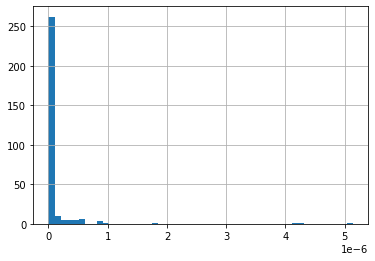

In [25]:
df_flux[df_flux.index.str.contains('ENZSYN-')].hist(bins=50)

<AxesSubplot:>

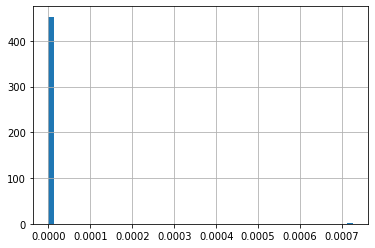

In [26]:
df_flux[df_flux.index.str.contains('PROSYN-')].hist(bins=50)

<AxesSubplot:>

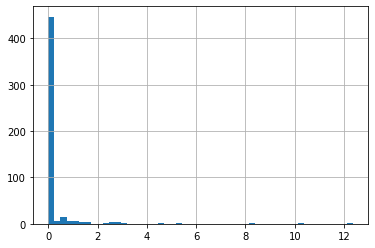

In [32]:
df_flux[df_flux.index.str.contains('RXN-')].hist(bins=50)

In [21]:
print(df_flux.idxmin(), df_flux.min())

ENZSYN-YGR267C 1.1361344399999986e-12


In [9]:
print(df_flux.idxmax(), df_flux.max())

RXN-H2Ot_c_m_REV-SPONT 12.347551392532004


In [28]:
df_flux[(df_flux.index.str.contains('ENZSYN-')) & (df_flux > 2e-6)]

ENZSYN-YBL030C       0.000005
ENZSYN-YJR077C       0.000004
ENZSYN-YPR192W_en    0.000004
Name: fluxes, dtype: float64

In [11]:
df_rxns = pd.read_excel('../scRBA_new/scRAM_network_frompy.xlsx')

In [29]:
df_rxns[df_rxns.reaction.str.contains('YBL030C')]

,id,type,symbolic_coeffs,reaction
1195,RXN-ADPATPt_c_m_FWD-YBL030C,metabolic,mu/keff,MET-adp_c + MET-atp_m + mu/keff ENZ-YBL030C --...
1196,RXN-ADPATPt_c_m_REV-YBL030C,metabolic,mu/keff,MET-adp_m + MET-atp_c + mu/keff ENZ-YBL030C --...
3838,ENZSYN-YBL030C,enzyme,NaN,2 PRO-YBL030C --> ENZ-YBL030C
4229,PROSYN-YBL030C,protein,mu*NAA/kribo,MET-fmettrna_c + MET-atp_c + 637 MET-h2o_c + 9...


In [30]:
df_rxns[df_rxns.reaction.str.contains('YJR077C')]

,id,type,symbolic_coeffs,reaction
1573,RXN-PItps_m_FWD-YJR077C,metabolic,mu/keff,MET-h_c + MET-pi_c + mu/keff ENZ-YJR077C --> M...
2610,RXN-PIt_m_mm_FWD-YJR077C,metabolic,mu/keff,MET-pi_m + mu/keff ENZ-YJR077C --> MET-pi_mm
2611,RXN-PIt_m_mm_REV-YJR077C,metabolic,mu/keff,MET-pi_mm + mu/keff ENZ-YJR077C --> MET-pi_m
3935,ENZSYN-YJR077C,enzyme,NaN,2 PRO-YJR077C --> ENZ-YJR077C
4710,PROSYN-YJR077C,protein,mu*NAA/kribo,MET-fmettrna_c + MET-atp_c + 623 MET-h2o_c + 6...


In [31]:
df_rxns[df_rxns.reaction.str.contains('YPR192W_en')]

,id,type,symbolic_coeffs,reaction
3186,RXN-H2Ot_c_e_FWD-YPR192W_en,metabolic,mu/keff,MET-h2o_e + mu/keff ENZ-YPR192W_en --> MET-h2o_c
3187,RXN-H2Ot_c_e_REV-YPR192W_en,metabolic,mu/keff,MET-h2o_c + mu/keff ENZ-YPR192W_en --> MET-h2o_e
3217,RXN-H2Ot_c_en_FWD-YPR192W_en,metabolic,mu/keff,MET-h2o_c + mu/keff ENZ-YPR192W_en --> MET-h2o_en
3218,RXN-H2Ot_c_en_REV-YPR192W_en,metabolic,mu/keff,MET-h2o_en + mu/keff ENZ-YPR192W_en --> MET-h2o_c
4162,ENZSYN-YPR192W_en,enzyme,NaN,PRO-YPR192W_en --> ENZ-YPR192W_en
5135,PROSYN-YPR192W_en,protein,mu*NAA/kribo,MET-fmettrna_c + MET-atp_c + 611 MET-h2o_c + 1...


In [33]:
df_flux[(df_flux.index.str.contains('PROSYN-')) & (df_flux > 0.0005)]

PROSYN-DUMMYPRO_c    0.000725
Name: fluxes, dtype: float64